# Previsão do número de mortos para Brasil 
### Análise matemática simples do crescimento da infeção, em Python

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

## Selecionar apenas os valores "TOTAL" do dataset, onde tem a soma de todas as zonas para um determinado dia

In [2]:
# dataset obtido no github de wcota
url = "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv"
df = pd.read_csv(url)
df=df[df['state']=='TOTAL']
print(df)

              date country  state   city  ibgeID  newDeaths  deaths  newCases  \
1       2020-02-25  Brazil  TOTAL  TOTAL       0          0       0         1   
3       2020-02-26  Brazil  TOTAL  TOTAL       0          0       0         0   
5       2020-02-27  Brazil  TOTAL  TOTAL       0          0       0         0   
7       2020-02-28  Brazil  TOTAL  TOTAL       0          0       0         1   
9       2020-02-29  Brazil  TOTAL  TOTAL       0          0       0         0   
...            ...     ...    ...    ...     ...        ...     ...       ...   
118538  2020-05-25  Brazil  TOTAL  TOTAL       0        731   23586     12912   
122543  2020-05-26  Brazil  TOTAL  TOTAL       0       1052   24638     16227   
126594  2020-05-27  Brazil  TOTAL  TOTAL       0       1054   25692     19769   
130711  2020-05-28  Brazil  TOTAL  TOTAL       0       1168   26860     28592   
134893  2020-05-29  Brazil  TOTAL  TOTAL       0       1146   28006     26423   

        totalCases  deaths_

## Data preparation
#### Primeiro, precisamos alterar as datas em números. Considera-se os dias desde 2020-02-25

In [3]:
df = df.loc[:,['date','deaths']]
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days  )

## The logistic model

In [4]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

#### Podemos usar a função curve_fit da biblioteca scipy para estimar os valores e erros dos parâmetros a partir dos dados originais.

In [5]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])
a,b,c=fit[0]


#### A função também retorna a matriz de covariância, cujos valores diagonais são as variações dos parâmetros. Tomando a raiz quadrada, podemos calcular os erros padrão.

In [6]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]


#### Podemos usar a função fsolve do scipy para encontrar numericamente a raiz da equação que define o dia final da infecção.

In [7]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))


## Exponential model
#### Vamos definir a função no Python e executar o mesmo procedimento de ajuste de curva usado para o crescimento logístico.

In [8]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))
exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1], maxfev=3000)

C:\OSGEO4~1\apps\Python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Plots
#### Agora temos todos os dados necessários para visualizar nossos resultados.

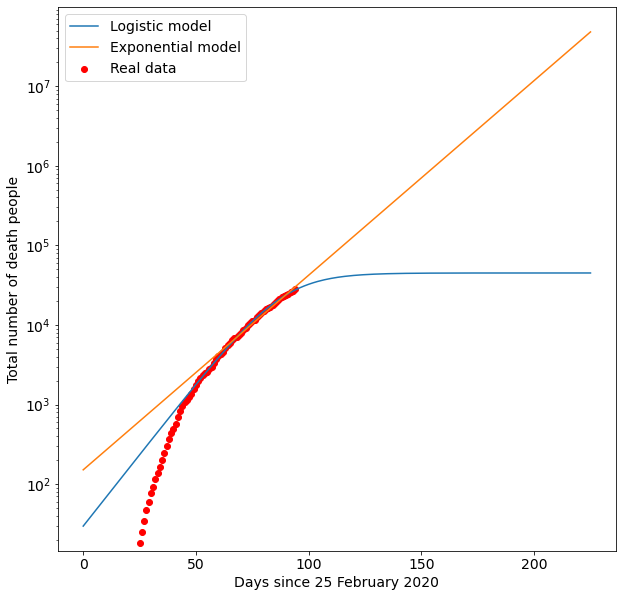

In [9]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
# Predicted exponential curve
plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 25 February 2020")
plt.ylabel("Total number of death people")
#plt.ylim((min(y)*0.9,c*1.1))
plt.yscale('log')
plt.savefig('Model2-Deaths.png')
plt.show()

#### Verifica-se que o modelo prevê que o número de mortos irá crescer até uma assintota situada entre 30.000 e 40.000 mortos

In [10]:
y_pred_logistic = [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x]
y_pred_exp =  [exponential_model(i,exp_fit[0][0], exp_fit[0][1], exp_fit[0][2]) for i in x]
print("Logistic mean_squared_error",mean_squared_error(y,y_pred_logistic))
print("Exponential mean_squared_error",mean_squared_error(y,y_pred_exp))

Logistic mean_squared_error 40325.19440584824
Exponential mean_squared_error 523806.1279153478
